# BANK MARKETING PROJECT

The following project focus on the analysis of a dataset 'Bank Marketing' which contains data about customers and aims to get useful insights from the data and predict if a new customer will accept a deposit offer or not.<br>

The project is structured as follows:

- Data Cleaning + Feature Engineering
- Exploratory Data Analysis
- Data preparation for ML algorithms (encoding)
- XGBOOST training and Hyperparameter optimization
- Results Summary

# Campaign Success Prediction results dashboard:

**NOTE: The dataset contains lots of missing, unknown or 'other' values for categorical features, which is bad for prediction. It is recommended to the company to collect better the data and have less uncertain values.**

- XGBoost achives good results in terms of precision, recall and accuracy, with values around 70%.
- The most important features to determine if a new customer will accept the deposit is poutcome (>30%):<br>
    - **This means that the deposit satisfied the customers who accepted it previously, however, currently, the company is probably aiming at the 'wrong' customers** 
 <br>
- Moreover, accoring to XGBoost, other important features to predict the success of a deposit are:
    - Contact: by looking at the data it looks like the great majority of customers with unknown contact did not accept the deposit: it should be investigated why these contacts are missing.
    - Housing: customers without housing loans seems to accept the deposit

<img src="https://i.imgur.com/8xFCrIJ.png" width="1000px">

# Bank Marketing Analysis results dashboard:

Main results from the data analysis:
- Customers who previously accepted the deposit tends to accept the deposit.
- Customers with job type as 'student' or 'retired' tends to accept the deposit, while blue collars tends to refuse the deposit.
- Customers without a personal loan tends to accept the deposit.
- Customers without a Housing Loan tends to accept the deposit.
- Customers tends to accept more the deposit on march, april, september and october.

<img src="https://i.imgur.com/3s4oCPA.png" width="1000px">

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bank-marketing-dataset/bank.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
  
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve


import xgboost as xgb

import optuna

seed=42

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

## Custom functions definition

In [3]:
def num_plot(df, col, title, symb):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col, data=df, ax=ax[0],color = "#1D8EF5")
    ax[0].set(yticks=[])
    sns.histplot(x=col, data=df, ax=ax[1],color = "#33AAFF", edgecolor="#1D1EA2")
    ax[1].set_xlabel(col, fontsize=16)
    plt.axvline(df[col].mean(), color='darkgreen', linestyle='--',linewidth=2.2, label='mean=' + str(np.round(df[col].mean(),1)) + symb)
    plt.axvline(df[col].median(), color='red', linestyle='--',linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)) + symb)
    plt.axvline(df[col].mode()[0], color='purple', linestyle='--',linewidth=2.2, label='mode='+ str(np.round(df[col].mode()[0],1)) + symb)
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
    plt.tight_layout()
    plt.show()

In [4]:
df=pd.read_csv('/kaggle/input/bank-marketing-dataset/bank.csv')

**Dataset information:**
#### bank client data:
1 - age (numeric)<br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
5 - default: has credit in default? (categorical: 'no','yes','unknown')<br>
6 - balance: bank balance <br>
7 - housing: has housing loan? (categorical: 'no','yes','unknown')<br>
8 - loan: has personal loan? (categorical: 'no','yes','unknown')<br>
#### Info related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: 'cellular','telephone')<br>
10 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
11 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
12 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
#### other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric;-1  means client was not previously contacted)<br>
15 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>

Output variable (desired target):<br>
17 - deposit - has the client subscribed a term deposit? (binary: 'yes','no')<br>



In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


We will first create a copy called 'df' of the original 'df1' dataset where we will perform data cleaning.

In [6]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


There no missing values and there are a lot of categorical features in the data. They will be analyzed first and then encoded before the ML training.

In [8]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


Some first insights on the data:<br>
- Age:
    - the medium age is 41 years old.
    - the minimum age is 18 years old.
    - the maximum age is 95 years old.
- Balance:
    - The std deviation looks high (3225) compared to the mean (1528).<br>
- Housing and deposit look balanced as their mean value is close to 0.5
- From the column 'previous' we can see that most of the clients have been already contacted, since the value is close to 1 (0.8325)
- Day should be converted to object type

In [9]:
df['day'] = df['day'].astype(object)

As written in the dataset description, the duration column should be dropped since it includes an information which cannot be known before the call to the client.

In [10]:
df=df.drop('duration', axis=1)

# Data Cleaning and Feature Engineering

First, we create a copy of the original dataframe where we will perform some data cleaning.

In [11]:
df_clean = df.copy()

In [12]:
df_clean.describe()

,age,balance,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,2.508421,51.330407,0.832557
std,11.913369,3225.413326,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,63.000000,854.000000,58.000000


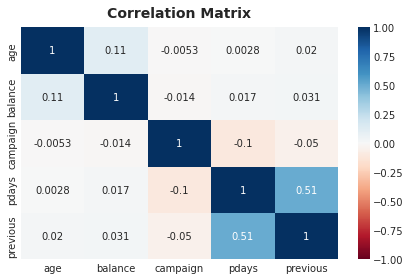

In [13]:
sns.heatmap(df.corr(), cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

From the correlation matrix, the only interesting correlation is the moderate positive correlation (+0.51) between 'previous' and pdays'.

## Age analysis

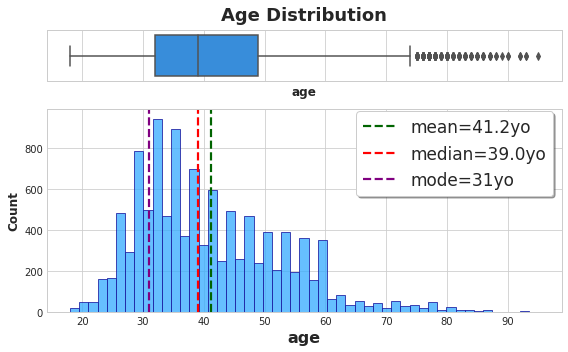

In [14]:
num_plot(df_clean, 'age', 'Age Distribution', 'yo')

The distribution of 'Age' is right skewed, with similar value of mean and median and a lower mode.

## Balance Analysis

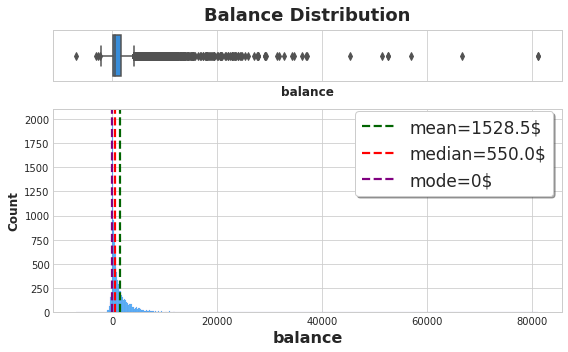

In [15]:
num_plot(df_clean, 'balance', 'Balance Distribution', '$')

The distribution is heavily right skewed, with some negative values as well.

## Campaign analysis

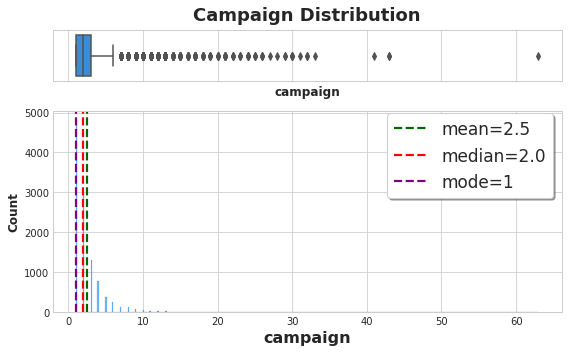

In [16]:
num_plot(df_clean, 'campaign', 'Campaign Distribution', '')

This variable presents a long tail distribtion, as the previous ones.

## pdays Analysis

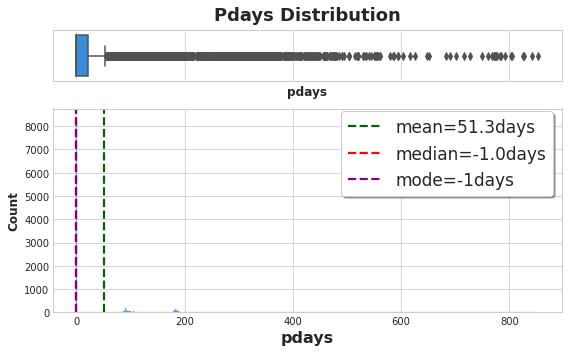

In [17]:
num_plot(df_clean, 'pdays', 'Pdays Distribution', 'days')

The great majority of customers in the dataset have pdays=-1 (not previously contacted). We could create a new binary feature to indentify customers who have previosuly been contacted or not.

In [18]:
df_clean['new_cust'] = df_clean['pdays'] == -1

In [19]:
df_clean['new_cust'] = df_clean['new_cust'].map({False:0, True:1})

# Exploratory Data Analysis

In [20]:
df=df_clean

To allow a better visualization, different palette will be chosen for the following plots.

In [21]:
palette = {'yes':'green', 'no':'red'}
palette = {'yes':'#46C646', 'no':'#FF0000'}

## Job Vs deposit

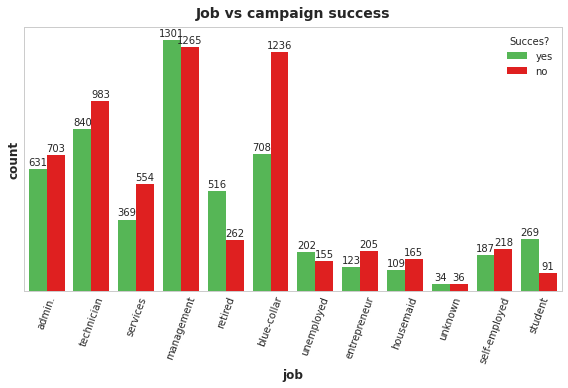

In [22]:
plt.figure(figsize=(8, 5.5));
plt.title('Job vs campaign success')
g = sns.countplot(x= 'job', hue = 'deposit', data=df, palette=palette)
plt.xticks(rotation=70)
plt.yticks([])
plt.legend(title='Succes?', ncol=1, fancybox=True, shadow=True)
for container in g.containers:
    g.bar_label(container, padding = 2)
plt.show()

**We can see that customers with job type as 'student' or 'retired' tends to accept the deposit, while 'blue collars' largely refused the deposit.**

## Marital Status vs campaign success

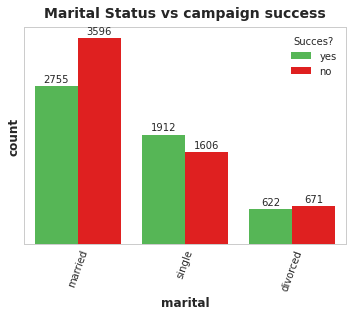

In [23]:
plt.figure(figsize=(5, 4.5));
plt.title('Marital Status vs campaign success')
g = sns.countplot(x= 'marital', hue = 'deposit', data=df, palette=palette);
plt.xticks(rotation=70)
plt.yticks([])
plt.legend(title='Succes?', ncol=1, fancybox=True, shadow=True)
for container in g.containers:
    g.bar_label(container, padding = 2)
plt.show()

**We cannot draw any particular conclusion.**

## Education vs campaign success

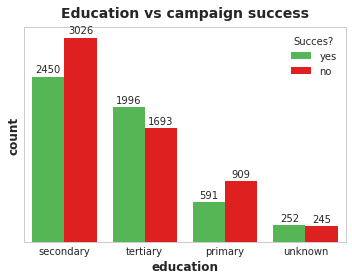

In [24]:
plt.figure(figsize=(5, 4));
plt.title('Education vs campaign success')
g = sns.countplot(x= 'education', hue = 'deposit', data=df, palette=palette);
plt.legend(title='Succes?', ncol=1, fancybox=True, shadow=True)
plt.yticks([])
for container in g.containers:
    g.bar_label(container, padding = 2)
plt.show()

**We cannot draw any particular conclusion.**

## Default vs campaign success

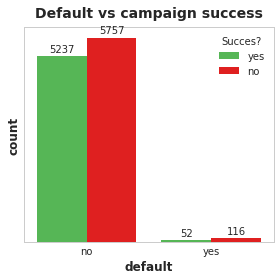

In [25]:
plt.figure(figsize=(4, 4));
plt.title('Default vs campaign success')
g = sns.countplot(x= 'default', hue = 'deposit', data=df, palette=palette);
plt.legend(title='Succes?', ncol=1, fancybox=True, shadow=True)
for container in g.containers:
    g.bar_label(container, padding = 2)
plt.yticks([])
plt.show()

**We do not have enough data for customers with default=1 to draw a conclusion.**

## Loan vs campaign success

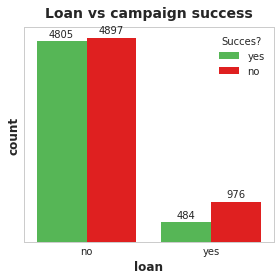

In [26]:
plt.figure(figsize=(4, 4));
plt.title('Loan vs campaign success')
g = sns.countplot(x= 'loan', hue = 'deposit', data=df, palette=palette);
plt.legend(title='Succes?', ncol=1, fancybox=True, shadow=True)
for container in g.containers:
    g.bar_label(container, padding = 2)
plt.yticks([])
plt.show()

**It looks like that customers with a personal loan tends to refuse the deposit**

## Contact vs campaign success

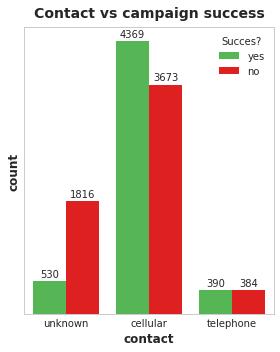

In [27]:
plt.figure(figsize=(4, 5));
plt.title('Contact vs campaign success')
g = sns.countplot(x= 'contact', hue = 'deposit', data=df, palette=palette);
plt.legend(title='Succes?', ncol=1, fancybox=True, shadow=True)
plt.yticks([])
for container in g.containers:
    g.bar_label(container, padding = 2)
plt.show()

**We cannot draw any particular conclusion.**

## Housing vs campaign success

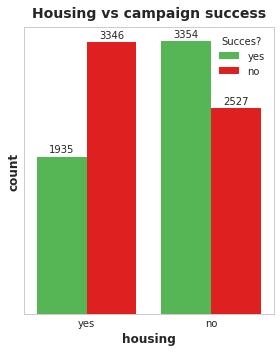

In [28]:
plt.figure(figsize=(4, 5));
plt.title('Housing vs campaign success')
g = sns.countplot(x= 'housing', hue = 'deposit', data=df, palette=palette);
plt.legend(title='Succes?', ncol=1, fancybox=True, shadow=True)
plt.yticks([])
for container in g.containers:
    g.bar_label(container, padding = 2)
plt.show()

**Customers without a Housing Loan tends to accept the deposit.**

## Day vs campaign success

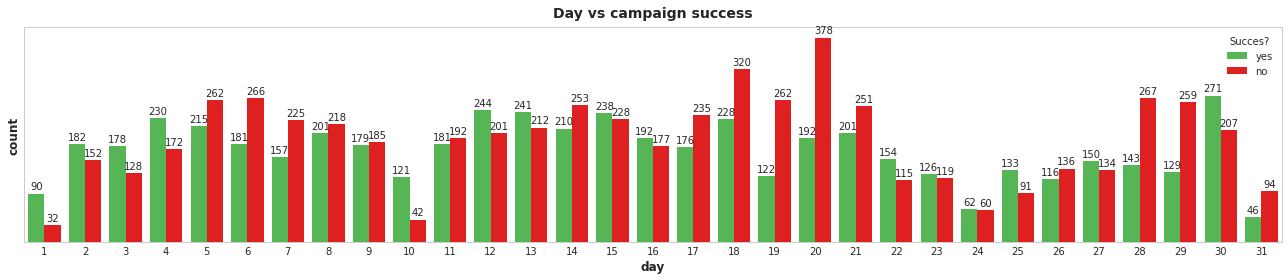

In [29]:
plt.figure(figsize=(18, 4));
plt.title('Day vs campaign success')
g = sns.countplot(x= 'day', hue = 'deposit', data=df, palette=palette);
plt.legend(title='Succes?', ncol=1, fancybox=True, shadow=True)
plt.yticks([])
for container in g.containers:
    g.bar_label(container, padding = 2)
plt.show()

**We cannot draw any particular conclusion.**

## Month vs campaign success

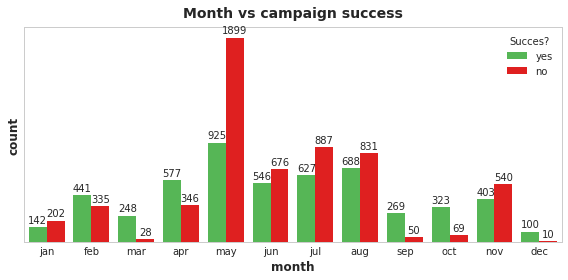

In [30]:
plt.figure(figsize=(8, 4));
plt.title('Month vs campaign success')
g = sns.countplot(x= 'month', hue = 'deposit', data=df, order=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'], palette=palette);
plt.legend(title='Succes?', ncol=1, fancybox=True, shadow=True)
plt.yticks([])
for container in g.containers:
    g.bar_label(container, padding = 2)
plt.show()

**It looks like that customers tends to accept more the deposit on march, april, september and october.**

## Poutcome vs campaign success

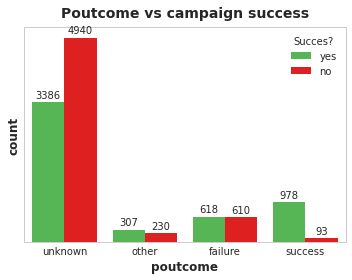

In [31]:
plt.figure(figsize=(5, 4));
plt.title('Poutcome vs campaign success')
g = sns.countplot(x= 'poutcome', hue = 'deposit', data=df, palette=palette);
plt.legend(title='Succes?', ncol=1, fancybox=True, shadow=True)
plt.yticks([])
for container in g.containers:
    g.bar_label(container, padding = 2)
plt.show()

**We can see that customers who previously accepted the deposit tends to accept the deposit by a large margin.**

## New_cust VS campaign success

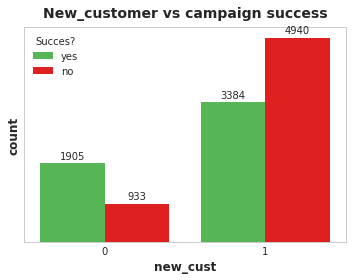

In [32]:
plt.figure(figsize=(5, 4));
plt.title('New_customer vs campaign success')
g = sns.countplot(x= 'new_cust', hue = 'deposit', data=df, palette=palette);
plt.legend(title='Succes?', ncol=1, fancybox=True, shadow=True)
plt.yticks([])
for container in g.containers:
    g.bar_label(container, padding = 2)
plt.show()

**We can see that customers who had previously been contacted tends to accept the deposit**

Is there a relationship between balance and age?

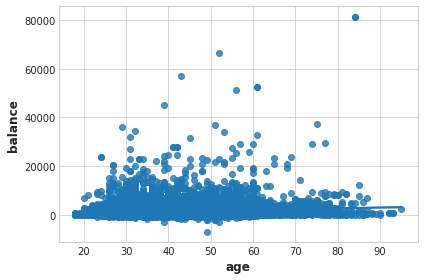

In [33]:
sns.regplot(x='age',y='balance', data=df)
plt.show()

This plot looks messy, we will create a categorical column for 'age'.

In [34]:
df['age_cate'] = pd.cut(df['age'], bins=[0, 35, 55, 70, float('Inf')], labels=['0-35', '35-55', '55-70', '70-95'])

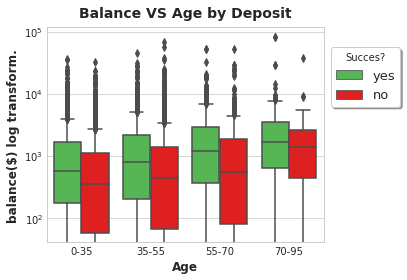

In [35]:
plt.figure(figsize=(6,4))
sns.boxplot(x='age_cate', y='balance', hue='deposit', data=df, palette=palette)
plt.ylabel('balance($) log transform.')
plt.xlabel('Age')
plt.title('Balance VS Age by Deposit')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.3, 0.6), title='Succes?', loc = 'lower right', fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

From this plot we can see that older customers tends to have a higher bank balance and that customers who accepted the deposit tended to have a higher balance compared to the customers who refused the deposit.

# Data Preparation for ML algorithms

In this section, we will perform some data preprocessing on the features. First, we will perform some transformations on skewed features.

# Categorical Features encoding

First, we encode the target variable.<br>
We note that the target column presents just two possible values: 'yes' or 'no'. Since these binary values appears in more columns, we encode all the 'yes' and 'no' in the whole dataframe with 0 and 1.

In [37]:
df_clean = df_clean.replace(['yes','no'], [1,0])

Then, we can analysze the remaing categorical features.

In [38]:
cat_feat = df_clean.select_dtypes(include="object").columns

In [39]:
cat_feat

Index(['job', 'marital', 'education', 'contact', 'month', 'poutcome'], dtype='object')

Depending on the categorical feature, we will choose if encoding it by one hot encoding or leabel encoding.

## Job

In [40]:
df_clean['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

There is no hierarchy, so this variable should be encoded by one hot encoding. Moreover, there are 63 samples with unknown jobs: we will label them as nan values and let XGBoost encode them.

In [41]:
df_clean['job'] = df_clean['job'].replace('unknown', np.nan)

## Age cate

In [42]:
df_clean['age_cate'].value_counts()

35-55    5307
0-35     4371
55-70    1211
70-95     273
Name: age_cate, dtype: int64

We can encode this feature by ordinal encoding

In [43]:
df_clean['age_cate'] = df_clean['age_cate'].map({'0-35':0,'35-55':1,'55-70':2,'70-95':3})

## Marital status

In [44]:
df_clean['marital'].value_counts()

married     6351
single      3518
divorced    1293
Name: marital, dtype: int64

We can encode this variable by ordinal encoding.

In [45]:
df_clean['marital'] = df_clean['marital'].map({'single':0,'married':1,'divorced':2})

## Education

In [46]:
df_clean['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

We can encode this feature with ordinal encoding. Moreover, there are 417 samples with unknown education: they will be labeled as nan values.

In [47]:
df_clean['education'] = df_clean['education'].map({'primary':0,'secondary':1,'tertiary':2, 'unknown':np.nan})

## Contact

In [48]:
df_clean['contact'].value_counts()

cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64

There is no hierarchy among these features. However since there are just 2 features excluding 'unknown', we could impute these by 1 and 0. <br>
We will replace the rows with unknown contact with nan values.

In [49]:
df_clean['contact'] = df_clean['contact'].map({'telephone':0,'cellular':1, 'unknown':np.nan})

## Month

In [50]:
df_clean['month'].value_counts()

may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: month, dtype: int64

We can encode the month feature by ordinal label encoding.

In [51]:
df_clean['month'] = df_clean['month'].map({'jan':0,'feb':1,'mar':2,'apr':3,'may':4,'jun':5,'jul':6,'aug':7,'sep':8,'oct':9,'nov':10,'dec':11})

## Poutcome

In [52]:
df_clean['poutcome'].value_counts()

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

The great majority of customers have missing values for poutcome (over 7000) meaning that most of the customers have not been previously contacted. We will encode the feature by one hot encoding and drop the rows with 'poutcome='other' since it is not clear what it means.

In [53]:
df_clean = df_clean[df_clean['poutcome']!='other']

In [54]:
df_clean['poutcome'] = df_clean['poutcome'].replace('unknown',np.nan)

In [55]:
df_clean.isna().sum()

age             0
job            69
marital         0
education     473
default         0
balance         0
housing         0
loan            0
contact      2339
day             0
month           0
campaign        0
pdays           0
previous        0
poutcome     8326
deposit         0
new_cust        0
age_cate        0
dtype: int64

We encode the remaining features with one hot encoding:

In [56]:
encoded_df = pd.get_dummies(df_clean, drop_first=True)

In [57]:
X = encoded_df.drop('deposit', axis=1)
y = encoded_df['deposit']

## Train - Test split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

## Train - Validation split

Then we further split the train set into a new train and validation set to monitor the accuracy on the validation set and prevent overfitting.

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, stratify=y_train, random_state=42)

# XGBoost

In [62]:
def objective(trial, X_train=X_train, X_val=X_val, y_train=y_train, y_val=y_val):
    param = {
        'objective' : 'binary:logistic',
        'eval_metric' : 'auc',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2,0.5),
        'n_estimators': trial.suggest_categorical('n_estimators', [1000,1500,2000,2500,3000,3500]),
        'max_depth': trial.suggest_int('max_depth', 3,10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
    }


    model = xgb.XGBClassifier(**param,use_label_encoder=False)    
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False,)   
    preds = model.predict(X_val)
    score = accuracy_score(y_val, preds)

    return score

In [63]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")

hp = study.best_params

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-12-03 23:14:04,298] A new study created in memory with name: no-name-d02004dd-ff34-4a00-82ba-0a82286571c0
[I 2021-12-03 23:14:04,928] Trial 0 finished with value: 0.7262745098039216 and parameters: {'lambda': 0.2522986910313705, 'alpha': 0.15128797087699297, 'colsample_bytree': 0.39547997217812736, 'subsample': 0.8, 'learning_rate': 0.1117731987522762, 'n_estimators': 3500, 'max_depth': 3, 'min_child_weight': 13}. Best is trial 0 with value: 0.7262745098039216.
[I 2021-12-03 23:14:06,128] Trial 1 finished with value: 0.7349019607843137 and parameters: {'lambda': 0.2698429284469768, 'alpha': 0.029274405949942968, 'colsample_bytree': 0.31933903420723486, 'subsample': 0.6, 'learning_rate': 0.09730153942876109, 'n_estimators': 2000, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 1 with value: 0.7349019607843137.
[I 2021-12-03 23:14:07,698] Trial 2 finished with value: 0.744313725490196 and parameters: {'lambda': 0.6345089347451764, 'alpha': 0.0011566550940203077, 'colsample_

Number of finished trials:  50
Best trial:
  Value: 0.7482352941176471
  Params: 
    lambda: 3.2113996133610914
    alpha: 0.048968785548235506
    colsample_bytree: 0.44324285737084246
    subsample: 0.8
    learning_rate: 0.01010639260079777
    n_estimators: 3000
    max_depth: 9
    min_child_weight: 7


In [64]:
xgb_model = xgb.XGBClassifier(**hp)

In [65]:
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=0)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:16:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=0.048968785548235506, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.44324285737084246, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              lambda=3.2113996133610914, learning_rate=0.01010639260079777,
              max_delta_step=0, max_depth=9, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=3000, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.0489687845,
              reg_lambda=3.21139956, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
y_pred_xgb = xgb_model.predict(X_test)

# Results Summary

In [67]:
print(classification_report(y_test, y_pred_xgb,target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       0.72      0.83      0.77      1129
         Yes       0.77      0.64      0.70       996

    accuracy                           0.74      2125
   macro avg       0.74      0.73      0.73      2125
weighted avg       0.74      0.74      0.74      2125



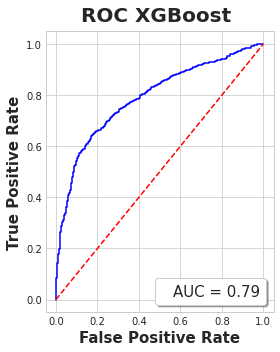

In [68]:
plt.figure(figsize = (4, 5))

probs = xgb_model.predict_proba(X_test)
preds = probs[:,1]
fprxgb, tprxgb, _ = roc_curve(y_test, preds)
roc_aucxgb = auc(fprxgb, tprxgb)

plt.plot(fprxgb, tprxgb, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC XGBoost ',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)
plt.show()

# Feature Importance

In [69]:
xgb_model.feature_names = encoded_df.drop('deposit', axis = 1).columns
feat_df= pd.DataFrame({'feature': xgb_model.feature_names,'importance':xgb_model.feature_importances_})
sorted_df=feat_df.sort_values('importance', ascending=False)

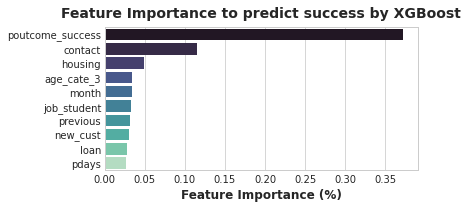

In [70]:
plt.figure(figsize=(6,3))
sns.barplot(x='importance', y='feature', data=sorted_df.head(10), palette='mako' )
plt.title('Feature Importance to predict success by XGBoost')
plt.xlabel('Feature Importance (%)')
plt.ylabel('')
plt.show()

- The most important features to determine if a new customer will accept the deposit is poutcome (>30%):<br>
    - **This means that the deposit satisfied the customers who accepted it previously, however, currently, the company is probably aiming at the 'wrong' customers** 
 <br>
- Moreover, accoring to XGBoost, other important features to predict the success of a deposit are:
    - Contact: by looking at the data it looks like the great majority of customers with unknown contact did not accept the deposit: it should be investigated why these contacts are missing.
    - Housing: customers without housing loans seems to accept the deposit
    

**Thanks for reading my notebook ! Let me know if you have questions or if you want me to check out your works !!**